### Notes
* we have to prevent the model from memorizing a specific patient's skin tone.
* LightGBM treats missing values (NaNs) as a special branch in the tree. It will decide if "missing" is more likely to be benign or malignant on its own.

### TODO next
* xgboost, catboost instead of lightgbm?
* more feature engineering? For example features related to patient, like area / mean area of all lesions for that patient_id

In [322]:
import os
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [323]:
train_df = pd.read_csv('../../data/train-metadata.csv')
train_df.head(3)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040


In [ ]:
# df_benign = train_df[train_df['target'] == 0].sample(n=6000, random_state=1)
# df_malignant = train_df[train_df['target'] == 1].sample(n=300, random_state=1)
# train_df = pd.concat([df_benign, df_malignant])
# train_df['target'].value_counts()

target
0    6000
1     300
Name: count, dtype: int64

In [325]:
num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']

final_cols = num_cols + cat_cols

In [326]:
def preprocess(train_df):
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(train_df[cat_cols])

    onehot_encoded_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]
    #     File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py", line 313, in _safe_call
    #     raise LightGBMError(_LIB.LGBM_GetLastError().decode("utf-8"))
    # lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name
    train_df[onehot_encoded_cols] = encoder.transform(train_df[cat_cols])
    train_df[onehot_encoded_cols] = train_df[onehot_encoded_cols].astype('category')

    for col in cat_cols:
        final_cols.remove(col)

    final_cols.extend(onehot_encoded_cols)

    return train_df

In [327]:
def evaluate(model, X, y_true):
    y_hat = model.predict_proba(X)[:]
    return y_hat # TODO

In [328]:
train_df = preprocess(train_df)

In [329]:
X = train_df[final_cols]
y = train_df['target']
groups = train_df['patient_id']
cv = StratifiedGroupKFold(3, shuffle=True, random_state=1)

In [330]:
def plot_cm(model, X_train, y_train, X_val, y_val, fold_num, experiment_num):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    datasets = [(X_train, y_train, 'Train'), (X_val, y_val, 'Validation')]
    
    for ax, (X_data, y_true, name) in zip(axes, datasets):
        y_pred = model.predict(X_data)
        cm = confusion_matrix(y_true, y_pred)
        
        # Labels setup
        group_names = ['TN', 'FP', 'FN', 'TP']
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)

        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False,
                    xticklabels=['Benign (0)', 'Malignant (1)'],
                    yticklabels=['Benign (0)', 'Malignant (1)'])
        
        ax.set_title(f'Fold {fold_num} - {name}')
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')

    save_dir = Path(f'../../images/gbdt/{experiment_num}')
    save_dir.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_dir / f'cm_fold_{fold_num}.jpg')
    plt.show()

In [331]:
lgb_params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'scale_pos_weight': 2,
    'verbosity': 1
}
# lgb_params = {
#     'objective':        'binary',
#     'verbosity':        -1,
#     'n_iter':           200,
#     'n_jobs':           2,
#     'boosting_type':    'gbdt',
#     'lambda_l1':        0.03335206514282942, 
#     'lambda_l2':        0.005157393323802471, 
#     'learning_rate':    0.030665870185795318, 
#     'max_depth':        7, 
#     'num_leaves':       239, 
#     'colsample_bytree': 0.7573175155547233, 
#     'colsample_bynode': 0.5005423904042993, 
#     'bagging_fraction': 0.7937347683420382, 
#     'bagging_freq':     4, 
#     'min_data_in_leaf': 29, 
#     'scale_pos_weight': 1.648349898918236,
# }

In [332]:
dirs = os.listdir('../../images/gbdt')
if len(dirs) == 0:
    experiment_num = 0
else:
    experiment_num = max([int(i) for i in dirs]) + 1
experiment_num

4

---[ Fold 1 ]---
[LightGBM] [Info] Number of positive: 194, number of negative: 4281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8340
[LightGBM] [Info] Number of data points in the train set: 4475, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043352 -> initscore=-3.094084
[LightGBM] [Info] Start training from score -3.094084


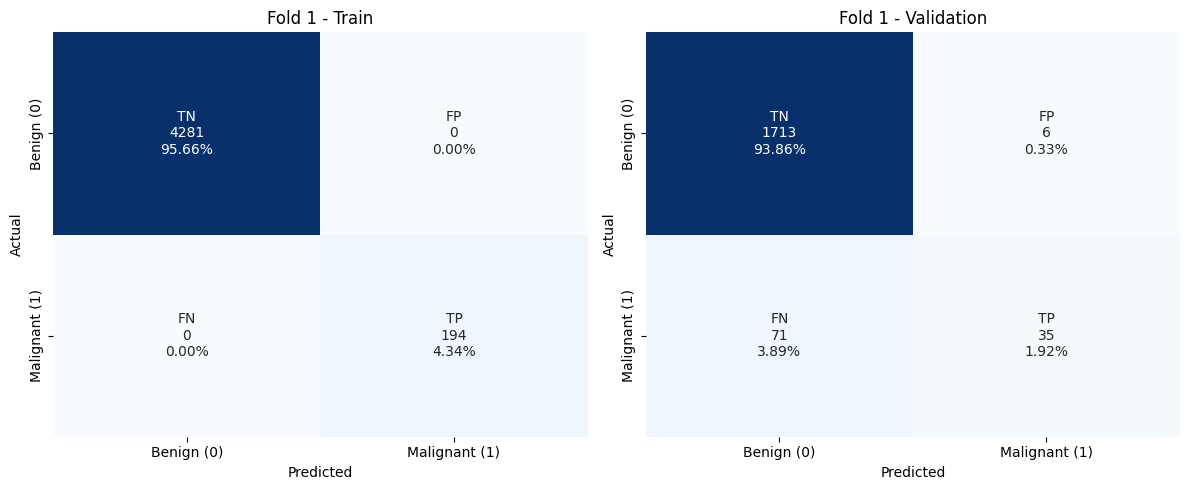

---[ Fold 2 ]---
[LightGBM] [Info] Number of positive: 189, number of negative: 3996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8339
[LightGBM] [Info] Number of data points in the train set: 4185, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045161 -> initscore=-3.051302
[LightGBM] [Info] Start training from score -3.051302


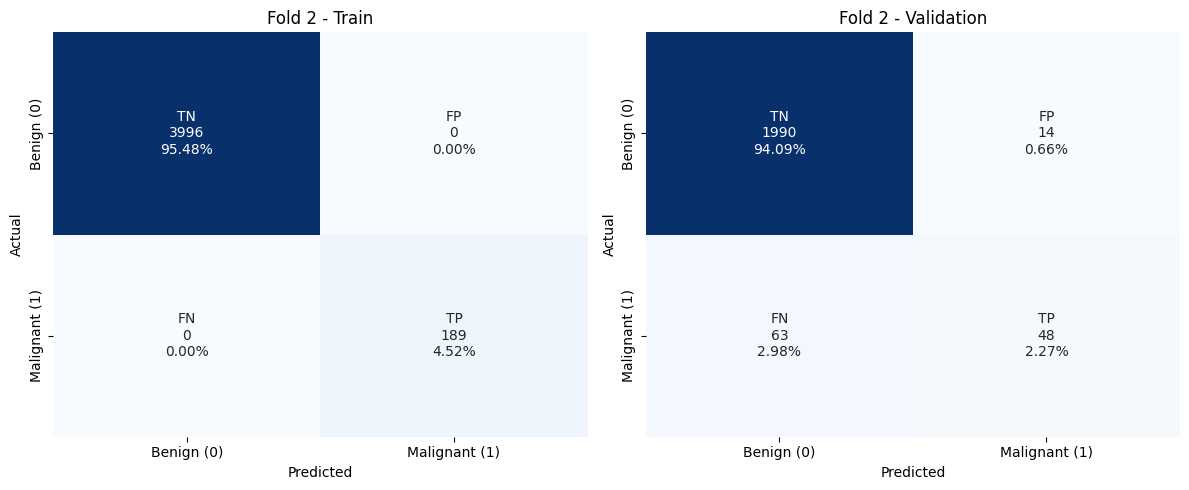

---[ Fold 3 ]---
[LightGBM] [Info] Number of positive: 217, number of negative: 3723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8338
[LightGBM] [Info] Number of data points in the train set: 3940, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055076 -> initscore=-2.842388
[LightGBM] [Info] Start training from score -2.842388


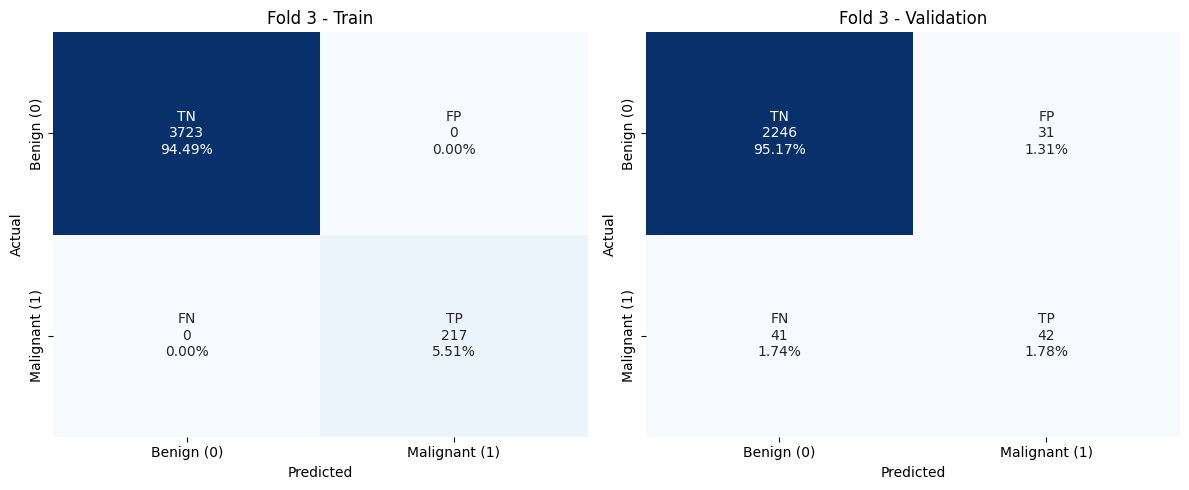

Mean AUC: 0.7074


In [333]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from datetime import datetime

exp_data = {'experiment_num': experiment_num,
            'data': []}

models = []
cv_scores = []
threshold = 0.5
for fold, (train_indices, val_indices) in enumerate(cv.split(X, y, groups=groups)):
    print(f'---[ Fold {fold + 1} ]---')

    X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

    model = lgb.LGBMClassifier(**lgb_params, random_state=1)
    # model = Pipeline([
    #     ('sampler', RandomUnderSampler(sampling_strategy=0.01, random_state=1)),
    #     ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=1))
    # ])
    model.fit(X_train, y_train) 
    y_probs = model.predict_proba(X_val)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    score = roc_auc_score(y_val, y_pred)
    report_dict = classification_report(y_val, y_pred, output_dict=True)

    fold_data = {
        "fold": fold + 1,
        "metrics": report_dict,
        "roc_auc": score,
    }

    exp_data['data'].append(fold_data)
    cv_scores.append(score)
    models.append(model)

    plot_cm(model, X_train, y_train, X_val, y_val, fold + 1, experiment_num)


mean_auc = np.mean(cv_scores)
std_auc = np.std(cv_scores)
history_file = 'experiments.md'

print(f'Mean AUC: {mean_auc:.4f}')

with open(history_file, 'a') as f:
    f.write(f"# Experiment: {experiment_num}\n")
    f.write(f"- **Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"- **Mean AUC:** `{mean_auc:.4f} +/- {std_auc:.4f}`\n")
    f.write(f"- **Threshold:** `{threshold}`\n\n")

    f.write("## Model Configuration\n")
    f.write(f"```python\n{repr(model)}\n```\n\n")

    f.write("## Fold Results\n")
    
    for fold_info in exp_data['data']:
        f_num = fold_info['fold']
        f.write(f"### Fold {f_num}\n")
        f.write(f"- **Fold AUC:** `{fold_info['roc_auc']:.4f}`\n\n")
        
        f.write("| Class | Precision | Recall | F1-Score |\n")
        f.write("| :--- | :--- | :--- | :--- |\n")
        
        for label in ['0', '1']:
            data = fold_info['metrics'][label]
            f.write(f'| {label} | {data['precision']:.4f} | {data['recall']:.4f} | {data['f1-score']:.4f} |\n')
        
        f.write("\n")

        img_path = f"../../images/gbdt/{experiment_num}/cm_fold_{f_num}.jpg"
        f.write(f"#### Confusion Matrix Fold {f_num}\n")
        f.write(f"![CM Fold {f_num}]({img_path})\n\n")
        
        f.write("---\n")

    f.write("\n\n")
